In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as anim
# from skimage import color

#### Functions
(For image processing)

come up with a common function for animation. That is, learn how to write animation function that takes multiple arguments.

03-07-2024 - as of now, I need to define a new animation function for each set of images, because I only know how to write animation function that takes only one argument.

[low prio] additional cleaning for displaying images. (see previous versions of this notebook)

### integer $l$, varying phase completeness

for fixing - labels should be $l \in [1, 5]$ not $l \in [0, 4]$

In [2]:
# plot_grid_imgs(int_imgs) # shape (5, 11)

#### "raw" intensity profile
sum of all pixel values

refer to: Baluyot & Hermosa, "Intensity profiles and propagation of optical
beams with bored **helical** phase"

mod for presentation (optional):
- normalization to a higher maximum: increase the intensity of the beams without changing the relative intensities betw. pics
- but use raw images for data analysis!

#### cylindrical lens
12/02/2024
Alperin, et al. 2016

for now, only the complete phase (P1=1.0) is animated

sum of pixel values

### fractional $l$ = varying phase completeness

method: cylindrical lens

increments of 0.2, $l \in [3, 5]$ (ignore the labels at the extreme left - they're wrong)\
03-07-2024 So far, operating on __complete__ phase, to verify if taking the centroid is a suitable method to measure OAM (method in Alperin's paper)

### fractional $l$ = complete phase only

#### cylindrical lens

In [3]:
# plot_grid_imgs(cyl_frac_imgs)

Animate only the complete phase

##### centroid
For images of beams passed through cylindrical lens
centroid ~ center of mass (where mass : intensity)

Now plot the centroid __w.r.t. centroid at $l=0$__

So far, the intensity centroid does not exhibit any clear relationship with topological charge. __Failed to replicate the graphs of Alperin (2016)__

#### raw intensity profiles
Can we use the known raw beam profile corresponding to topological charges to tell the __effective__ $l$ of incomplete phase?

In [8]:
l_imgs = np.round(np.linspace(start=0, stop=5, num=26), 2)
frac_imgs = []

for l_i in l_imgs:
    img = plt.imread(f'05-02-2024 frac l complete/l={l_i}, P1=1.0.png')
    frac_imgs.append(img)

frac_imgs = np.array(frac_imgs)

In [9]:
frac_imgs.shape

(26, 2016, 2016, 3)

[convert the next two cells to code when you need to export the animation (for presentation)]

In [14]:
def show_im_frac(n):
    img = frac_imgs[n, :, :, :]
    ax.clear()
    ax.imshow(img, cmap='hot', animated=True)
    ax.set_title(f'l = {l_imgs[n]}')

In [21]:
# %matplotlib tk
fig, ax = plt.subplots()

animate = anim.FuncAnimation(fig, show_im_frac, frames=frac_imgs.shape[0],
                             interval=200, repeat_delay=1000)
# plt.show()
animate.save(filename='frac_l.gif', writer='pillow')

# fig.clf()

#### Single mode fiber
Projection of a Gaussian mode onto a shaped beam as the beam travels through the optical fiber. Voltage read from an oscilloscope.

##### Statistics calculated in pythoh.
Took the raw voltage readings per $l$ from oscilloscope. Computed the average & standard deviation in Python.


In [2]:
def aggregate(var, values):
    conc = []
    
    # READ FILE
    for i, v in enumerate(values):
        try:
            # importing
            f = str(i).zfill(4)
            V = pd.read_csv(f'05-02-2024 SMF/ALL{f}/F{f}CH1.CSV', sep=',', header=None, 
                            usecols=[4], names=[f'{v}'])
            # timestamps aren't important, since all sheets have the same no. of data points (2500)
            
            # add to list of dataframes
            conc.append(V)
        
        # catch corrupted or deleted files
        except FileNotFoundError:
            pass # move on to the next iteration
        except UnicodeDecodeError:
            pass
        '''There are 2 possible errors (so far):
        - filenotfound: we deleted the file because of either: corruption or repeat measurement
        - unicode error: the file has no data on preview (hence only 1 row)'''
    
    return pd.concat(conc, axis=1) # join the voltage readings in the list

Import

In [3]:
l = np.round(np.concatenate([np.linspace(start=0, stop=1, endpoint=False, num=20),
                             np.linspace(start=1, stop=5, endpoint=True, num=41)], axis=0), 2)

raw = aggregate(var='l', values=l)
bg = pd.read_csv(f'05-02-2024 SMF/ALL0061/F0061CH1.CSV', sep=',', usecols=[4], header=None)

Cleaning

\begin{align}
gain = 10 \log\left(\frac{V_2}{V_1}\right)\\
ratio = \frac{V_2}{V_1} = 10^{\frac{gain}{10}}
\end{align}

In [4]:
# correct raw readings (l and bg) for photodetector gain
gain = 50 # amplification in dB
amp = 10**(gain/10) # direct ratio between voltages before and after photodetector
raw /= amp
bg /= amp

# subtract background from l signal
data = raw - bg.values
data.shape # 2500 data points x 61 l values

(2500, 61)

Compute statistics:
standard error (standard deviation of the mean):
$$\sigma_{\bar{x}} = \frac{\sigma_x}{\sqrt{N}}$$
where
$$\sigma_x = \sqrt{\frac{\sum (x - \bar{x})^2}{N-1}}$$

In [5]:
# take the best estimate of V -- the mean -- for each l:
V_mean = data.aggregate(['mean', 'std'], axis=0).T

# uncertainty: standard error
V_mean['std'] /= np.sqrt(data.shape[0])

sanity check: Is the data "uniformly noisy"? (There might be sharp features like the previous import, which I don't know the cause of.)

##### Plot. Mean voltage vs $l$
Highlight the coordinates of:
- max
- min

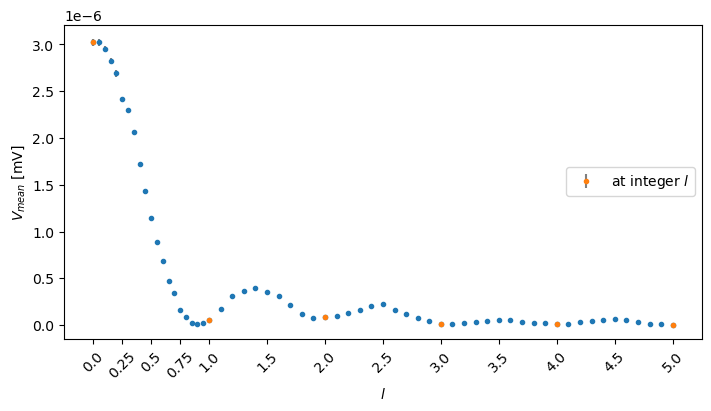

In [7]:
fig, ax = plt.subplots(layout='constrained', figsize=[7., 4.])

# plot values
ax.errorbar(x=l, y=V_mean['mean'], yerr=V_mean['std'], 
            fmt='.', ecolor='gray')

# should the error bars be bars or a shaded region?

# highlight integer values
V_intl = V_mean[l%1==0]
ax.errorbar(x=V_intl.index, y=V_intl['mean'], yerr=V_intl['std'],
            fmt='.', ecolor='gray', label='at integer $l$')

# for i, val in V_intl.iterrows():
#     ax.annotate(text=np.round(V_intl.loc[i, 'mean V'], 5), xy=(i, val['mean V']), xytext=(i, -0.005), color='red')

# plot parameters
ax.set(xlabel='$l$', ylabel='$V_{mean}$ [mV]', xticks=l[::5], xticklabels=l[::5])
ax.tick_params(axis='x', labelrotation=45)
ax.legend(loc='center right')
fig.savefig(fname='SMF 05-02-2024.pdf')

### to do - analysis
- Should I curvefit?
- test your functions, draw them out if you have to.
- from literature, come up with other ways to quantify the OAM of beams (complete phase)

### Outlook

Other methods to characterize vortices: single mode fiber, interferometry.
I also captured images of _negative_ topological charge through a cylindrical lens (not yet included in this notebook; I don't know if I will include it because there's nothing unexpected).

What can I find using my results?
- What is the threshold of the cylindrical lens being an effective way to quantify OAM? (based off Alperin)
- Try **fractional topological charge** (the Russian paper)
- What now is the topological charge when, for some initial l, the phase is more and more incomplete?


More data processing to try:
- Radon transform. What pattern will arise? With respect to what? is it more useful?
- get the centroid
- ~mode projection??~